In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

In [2]:
# Reding USD to JPY data from yahoo finance, date 2012-01-01 to 2022-12-31

data= yf.download("USDJPY=X", start="2012-01-01", end="2022-12-31")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-02,77.050003,77.089996,76.870003,77.019997,77.019997,0
2012-01-03,76.933998,76.954002,76.653000,76.930000,76.930000,0
2012-01-04,76.732002,76.814003,76.599998,76.722000,76.722000,0
2012-01-05,76.710999,77.129997,76.669998,76.709999,76.709999,0
2012-01-06,77.158997,77.308998,77.015999,77.151001,77.151001,0


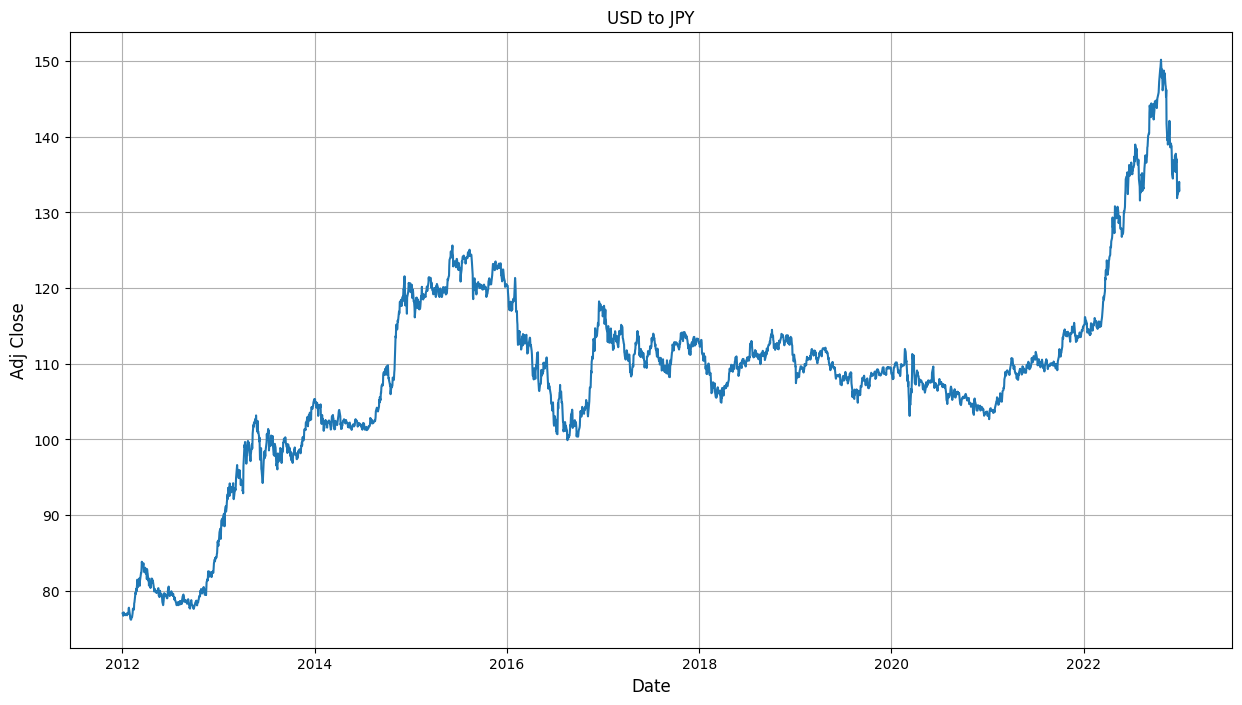

In [3]:
# Line plot of USD to JPY

plt.figure(figsize=(15,8))
plt.grid(True)
plt.title('USD to JPY')
plt.plot(data['Adj Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adj Close', fontsize=12)
plt.show()

## LSTM Model

In [4]:
# Importing libraries for LSTM

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

2024-09-03 15:24:19.457671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 15:24:19.601656: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 15:24:19.756195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 15:24:19.868861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 15:24:19.906898: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 15:24:20.125007: I tensorflow/core/platform/cpu_feature_gu

In [5]:
# Using Adj Close as the target variable
close_data = data['Adj Close'].values

# Reshaping the data for MinMax
close_data = close_data.reshape(-1,1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(close_data)

print(scaled_data)


[[0.01135192]
 [0.01013568]
 [0.00732472]
 ...
 [0.77444722]
 [0.78185308]
 [0.76674421]]


In [6]:
# Define the look-back period (number of previous time steps to use as input variables)
look_back = 60

# Create the dataset with a specific look-back period
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Create training and testing datasets
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10, verbose=1)

Epoch 1/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 57s 25ms/step - loss: 0.0019
Epoch 2/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 68s 30ms/step - loss: 3.3928e-04
Epoch 3/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - loss: 2.8337e-04
Epoch 4/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 292s 131ms/step - loss: 1.8289e-04
Epoch 5/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 73s 33ms/step - loss: 1.6481e-04
Epoch 6/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 88s 39ms/step - loss: 1.4297e-04
Epoch 7/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 104s 47ms/step - loss: 1.6280e-04
Epoch 8/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 109s 49ms/step - loss: 1.8012e-04
Epoch 9/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 110s 49ms/step - loss: 1.3565e-04
Epoch 10/10
2231/2231 ━━━━━━━━━━━━━━━━━━━━ 115s 51ms/step - loss: 1.2162e-04


In [9]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + look_back + 1:], y_test, label='Actual USD/JPY')
plt.plot(data.index[train_size + look_back + 1:], predictions, label='Predicted USD/JPY')
plt.plot(data.index[train_size + look_back + 1:], predictions, label='Predicted USD/JPY')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.title('LSTM Model - USD to YEN Exchange Rate Prediction')
plt.legend()
3plt.show()

ValueError: x and y must have same first dimension, but have shapes (514,) and (513, 1)

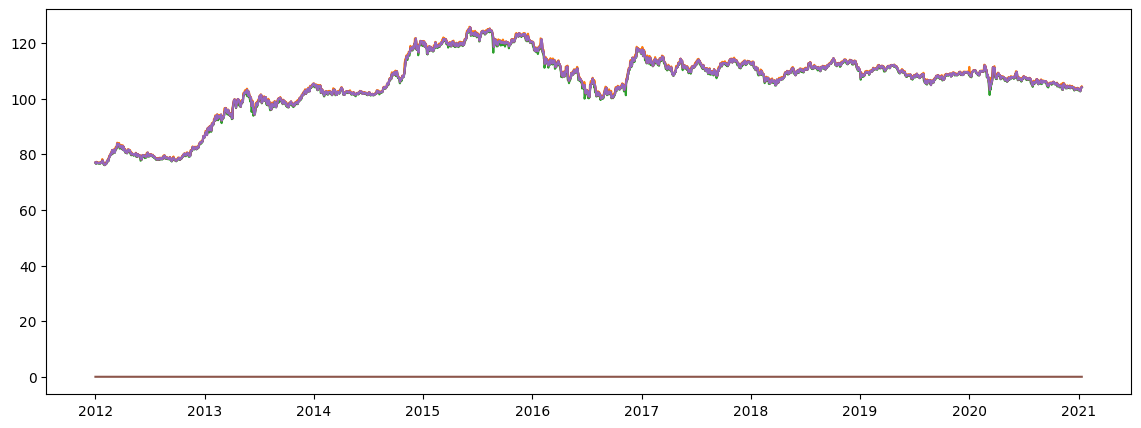

In [14]:
plt.figure(figsize=(14, 5))

# Plot the training data
plt.plot(data.index[:train_size + look_back], data[:train_size + look_back], label='Train USD/JPY')

# Plot the test data
plt.plot(data.index[train_size + look_back:], y_test, label='Test USD/JPY', color='orange')

# Plot the predicted data
plt.plot(data.index[train_size + look_back:], predictions, label='Predicted USD/JPY', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.title('LSTM Model - USD to YEN Exchange Rate Prediction')

# Show legend
plt.legend()

# Show the plot
plt.show()
